## Beam Sensitivity

Perform sensitivity analysis on beams

In progress - working on absorption function and comparing two methods for calculation.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib
import tri_mesh
import beam
import beam_utils
from scipy import interpolate

from lmfit.lineshapes import gaussian, voigt

## Read Jet Data

In [2]:
viz_path = r"C:\Users\Huckaby\Desktop\MHD\Simulations\viz_example" 
print(os.listdir(viz_path))
fname = "frontCyl_plasma.vtk"
fname = "frontCyl.vtk"
fname = os.path.join(viz_path, fname)
f_flow = beam_utils.new_soln_interpolator(fname, do_plot=False)

['.ipynb_checkpoints', 'ds_calib.cdf', 'frontCyl.vtk', 'frontCyl_plasma.vtk', 'output', 'plasma_properties.py', 'potassium_chemistry.py', 'rotate.ipynb', 'rotate.py', 'rotate_scipy.py', 'square.vtk', 'square2.vtk', 'thermo_example.py', 'Untitled.ipynb', 'viz_examples.py', '__pycache__']


In [3]:
#source

## Source Wavelength Profile

In [4]:
importlib.reload(beam_utils)
#dir(beam_uilts)

<module 'beam_utils' from 'C:\\Users\\Huckaby\\Desktop\\MHD\\Simulations\\PhotoIonization\\MHD-Photoionization\\modeling\\cfd\\beam_utils.py'>

In [5]:
data_path = r"C:\Users\Huckaby\Desktop\MHD\Simulations\viz_example"
fname = "ds_calib.cdf"
fname = os.path.join(data_path,fname)
source_wavelength = beam_utils.read_intensity_wavelength_function(fname, do_plot=False)
source_wavelength

<xarray.Dataset>
Dimensions:     (mp: 2, wavelength: 404, time: 2)
Coordinates:
  * mp          (mp) object 'barrel' 'mw_horns'
  * wavelength  (wavelength) float64 718.8 719.4 720.1 ... 810.8 811.2 811.6
  * time        (time) datetime64[ns] 2023-05-24T18:12:49.047832386 2023-05-2...
Data variables:
    led_on      (time, wavelength, mp) float64 ...
    led_off     (time, wavelength, mp) float64 ...
    diff        (time, wavelength, mp) float64 ...

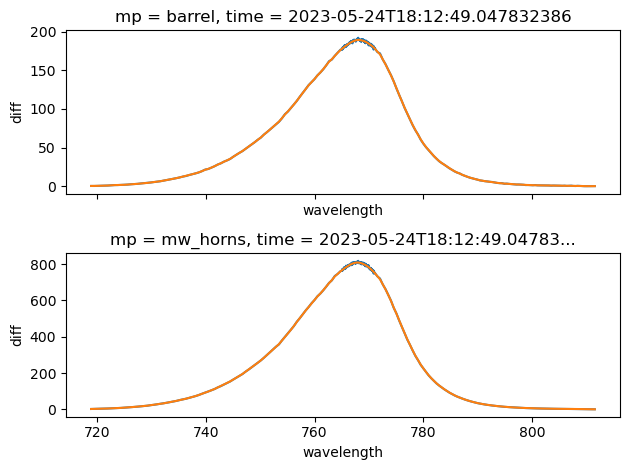

In [6]:
source_filt = beam_utils.filter_wave_profile(source_wavelength)
mp = "mw_horn"
fig, ax = plt.subplots(2,1,sharex=True)
for i in range(2):
    source_wavelength["diff"].isel(time=0,mp=i).plot(ax=ax[i])
    source_filt["diff"].isel(time=0,mp=i).plot(ax=ax[i])
fig.tight_layout()

## Beam

In [7]:
importlib.reload(tri_mesh)
importlib.reload(beam)

<module 'beam' from 'C:\\Users\\Huckaby\\Desktop\\MHD\\Simulations\\PhotoIonization\\MHD-Photoionization\\modeling\\cfd\\beam.py'>

In [8]:
def mag(x):
    return np.sum(x**2, axis=-1)**0.5

In [9]:
x_exit = 207.910 * 1e-3

# location of source relative to focus point
source_offset = np.array([-0.05,0.0,-0.1])
source_distance = mag(source_offset)
beam_dir = -source_offset/source_distance

target_distance = source_distance
target_offset = target_distance*beam_dir
print("target distance = {:8.2f} [cm]".format(target_distance*1e2))
print("source distance = {:8.2f} [cm]".format(source_distance*1e2))
# minumum
x_min = x_exit - source_offset[0]
x_focus = x_min
pos_focus = np.array([x_focus,0,0])

b = beam.Beam(source=pos_focus+source_offset,target=pos_focus+target_offset,diam=1e-2)

target distance =    11.18 [cm]
source distance =    11.18 [cm]


In [10]:
b.mesh(n_s=10,n_r=4,n_sides=6)



### Interpolate Field Data to Beam

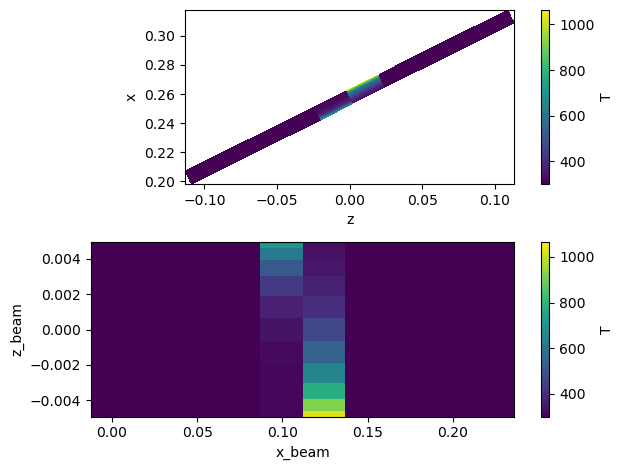

In [11]:
f_out = f_flow(b.ds["pos"])
b.ds["T"] = ("s","ray"), f_out[:,:,0].T
b.ds["K"] = ("s","ray"), f_out[:,:,1].T
fig, ax = plt.subplots(2,1)
ax[0].set_aspect(1.0)
#ax[1].set_aspect(1.0)
b.ds["T"].plot(x="z",y="x", ax=ax[0])
b.ds["T"].plot(x="x_beam",y="z_beam", ax=ax[1])
fig.tight_layout()

### Refine Mesh

In [12]:
import beam
importlib.reload(beam)
beam_adapt = beam.adapt_beam_dataset(b.ds, adapt_vars=["T","K"], field_func=f_flow, rtol=0.1, max_iter=20)
b.add_cart_coords(beam_adapt, "pos_beam", "{}_beam")

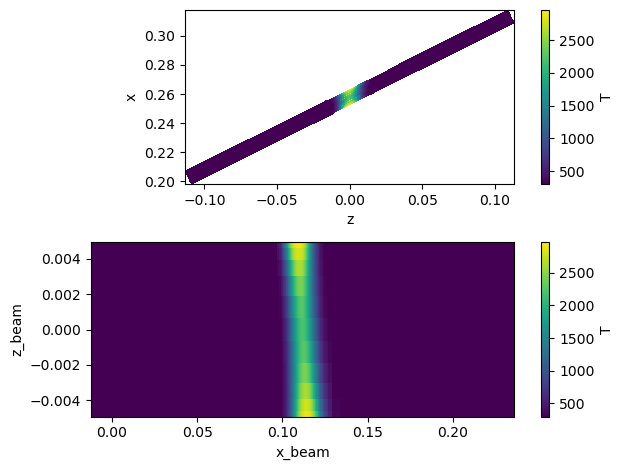

In [13]:
fig, ax = plt.subplots(2,1)
ax[0].set_aspect(1.0)
#ax[1].set_aspect(1.0)
beam_adapt["T"].plot(x="z",y="x", ax=ax[0])
beam_adapt["T"].plot(x="x_beam",y="z_beam", ax=ax[1])
fig.tight_layout()

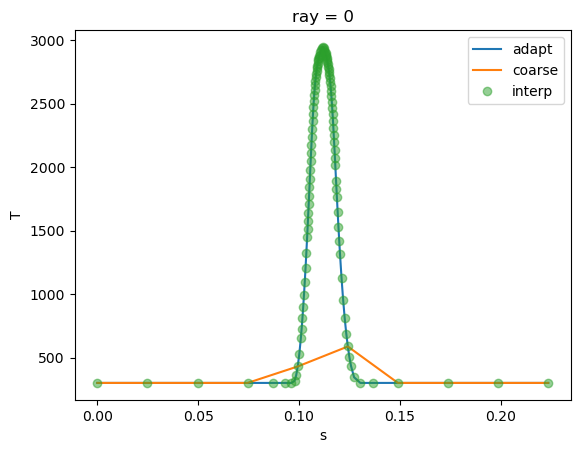

In [14]:
beam_adapt["T"].sel(ray=0).plot(label="adapt")
b.ds["T"].sel(ray=0).plot(label="coarse")
pos = beam_adapt["pos"].sel(ray=0)
f = f_flow(pos)
plt.plot(beam_adapt["s"], f[:,0], 'o', alpha=0.5, label="interp")
plt.legend()

## Calculate Intensity

In [15]:
#constants.Boltzmann, constants.R/constants.Avogadro

In [16]:
#Q_absorption.T0

### Potassium Cross Section

In [17]:
import ray_integration
import scipy.constants as constants
A0 = constants.e/(4.0*constants.epsilon_0*constants.m_e*constants.c**2)
lam_nm = np.array([766.504333,769.913219])
unit_nm = 1e-9
lam = lam_nm * unit_nm

f = np.array([ 0.7, 0.35 ])
A = A0*np.array([ 4.0/6.0*f[0]*lam[0]**2, f[1]*lam[1]**2 ])

MW_K = 39.1
mass_K = MW_K*constants.m_p
T_ref = 1000.0
k_B = constants.Boltzmann
f_delta_C = [3.19e9, 3.04e9]
delta_D = 2.0*np.sqrt(2.0*np.log(2.0)*k_B*T_ref/mass_K)*(lam/constants.c)
delta_C = (lam**2/constants.c)*f_delta_C

Q_absorption = ray_integration.GaussAbsorption(A=A,b=[-0.5,-0.5], lam=lam_nm, w=[5,5])
Q_absorption.Q0 = 1.0
print("lam/c", lam/constants.c)
delta_D/unit_nm, delta_C/unit_nm

lam/c [2.55678324e-15 2.56815406e-15]


(array([0.00276634, 0.00277865]), array([0.00625172, 0.00601086]))

In [18]:
unit_cm = 1e-2
E = 13042/unit_cm
E*constants.c

390989323723600.0

In [19]:
T = 1000.0
nu = np.sqrt(8.0*(constants.Boltzmann*T*np.log(2.0)/(constants.m_e*constants.c**2)))
lam = 770.0*unit_nm
nu_0 = 1.0/lam
nu_0/1e-2

129870129.87012987

8

collisional
freq [1/s] 1620558517.8042936
wavelength [nm] [0.00317595 0.00320426]
wave# [1/cm] 0.05405601357070476
doppler
freq [1/s] [1.41155394e+09 1.40530411e+09]
wavelength [nm] [0.00276634 0.00277865]
wave# [1/cm] [0.04708437 0.0468759 ]


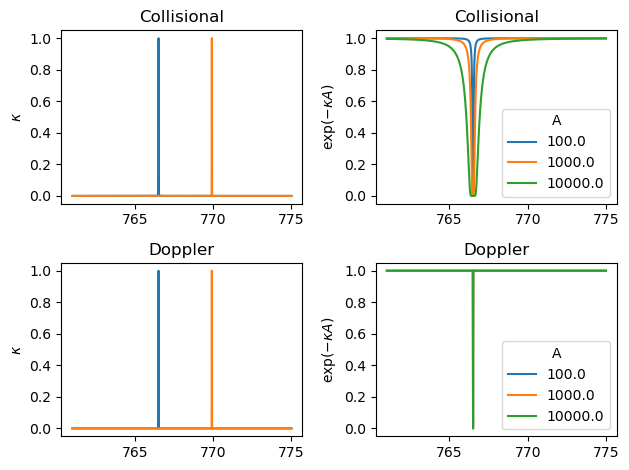

In [20]:
class VoigtAbsorption:

    p_atm = 101325.0
    
    def __init__(self):
        self.center = np.array([766.504333, 769.913219])
        self.stat_weight = np.array([4.0/6.0*0.7, 0.35])
        self.Deltaf = np.array([3.19e9,3.04e9])        
        self.MW = 39.1
        self.update()
    
    def update(self, p=1e5, T_ref=1000.0):
        unit_nm = 1e-9
        k_B = constants.Boltzmann/unit_nm**2
        c = constants.c/unit_nm
        N_A = constants.Avogadro
        
        self.mass = self.MW*N_A
        self.T_ref = T_ref
        self.sigma = 2.0*np.sqrt(2.0*np.log(2.0)*k_B*T_ref/self.mass)*(self.center/c)
        self.gamma = (self.center**2/c)*self.Deltaf

    def calc(self, T=300.0, p=1e5, lam_nm=760.0, verbose=True, do_plot=False):
        # https://cefrc.princeton.edu/sites/g/files/toruqf1071/files/Files/2013%20Lecture%20Notes/Hanson/pLecture6.pdf
        # natural broadening
        k_B = constants.Boltzmann
        c = constants.c

        lam_0 = self.center*unit_nm
        nu_0 = c/lam_0
        
        tau_u = 1e-8  # electronic
        tau_u = 1e-2  # vib-rot
        delta_nu_N = 1.0/(2.0*np.pi)/tau_u
        # collisional broadening, Lorentzian
        # Z_B = p*np.pi*Q_AB*np.sqrt(8.0/np.pi*mu_AB*k_B*T)
        # delta_nu_C = Z_B/np.pi
        unit_cm = 1e-2
        #     [1/(atm-m)] = [1/(atm-cm)] / [cm/m]
        two_gamma = 0.1/unit_cm
        #     [1/m] = [1/(atm-m)] [ ] [Pa/(Pa/atm)]
        delta_k_C = two_gamma*(300.0/T)**0.5*(p/self.p_atm)
        #     [1/s] = [1/m]*[m/s]
        delta_nu_C = delta_k_C*c
        
        delta_lam_C = (lam_0/nu_0)*delta_nu_C  
        if verbose:
            print("collisional")
            print("freq [1/s]", delta_nu_C)
            print("wavelength [nm]", delta_lam_C/unit_nm)
            print("wave# [1/cm]", delta_k_C*unit_cm)

        # dopler broadening
        mass = constants.m_p*self.MW
        nu_0 = c/(self.center*unit_nm)
        delta_nu_D = 2.0*np.sqrt(2.0*k_B*T*np.log(2)/(mass*c**2))*nu_0

        
        lam_0 = self.center*unit_nm
        delta_lam_D = delta_nu_D*lam_0/nu_0
        delta_k_D = delta_nu_D/c
        if verbose:
            print("doppler")     
            print("freq [1/s]", delta_nu_D)
            print("wavelength [nm]", delta_lam_D/unit_nm)
            print("wave# [1/cm]", delta_k_D*unit_cm)

        fig, ax = plt.subplots(2,2)

        for i in range(2):
            wave = np.linspace(self.center[0] - 5*delta_lam_D[0]/unit_nm, self.center[1] + delta_lam_D[1]/unit_nm*5.0, 100)
            wave = np.linspace(761,775,1000)
            nu = c/(wave*unit_nm)
            phi = [ delta_nu_C/( (nu - nu_0[i])**2 + (delta_nu_C/2)**2) for i in range(2)]
            ax[0,0].plot(wave, phi[i]/phi[i].max(), label="coll.".format(i))
    
            phi_D = [ np.exp( -( 2.0*np.sqrt(np.log(2))*(nu - nu_0[i])/delta_nu_D[i] )**2 ) for i in range(2)]
            #print(np.max(phi_D))
            ax[1,0].plot(wave, phi_D[i]/phi_D[i].max(), label="dopler{}".format(i))

           
            if i == 0:
                for j, f in enumerate([phi[i], phi_D[i]]):
                    kappa = f/f.max()                
                    for A in [1e2,1e3,1e4]:
                        ax[j,1].plot(wave, np.exp(-kappa*A), label="{}".format(A))
                    ax[j,1].legend()

        ax[0,1].legend(title="A")
        ax[1,1].legend(title="A")
        
        for i, name in enumerate(["Collisional","Doppler"]):
            ax[i,0].set_ylabel(r"$\kappa$")
            ax[i,1].set_ylabel(r"$\exp(-\kappa A)$")
            ax[i,0].set_title(name)
            ax[i,1].set_title(name)
        
        fig.tight_layout()

    def __call__(self, T, lam):        
        """voigt(x, amplitude=1.0, center=0.0, sigma=1.0, gamma=None)
        kappa = p1_prefactor*voigt(x, 1, p1_center, p1_delta_wl_D, p1_delta_wl_C) + p2_prefactor*voigt(x, 1, p2_center, p2_delta_wl_D, p2_delta_wl_C)
        """
        val = calc(lam, A[0], center[0], sigma[0], gamma[0])
        return val

Q_abs = VoigtAbsorption()
lam = np.linspace(761, 780, 100)
T = np.arange(500,3001,500)
#T = np.array([999,1001])
sigma = 3e-3*(T/1000.0)**0.5
gamma = 6e-3*5e2
center = 766.504333
#
# compare new function with older
# broken need to fix
#val = np.array([Q_abs.calc(lam, 1.0, center, sigma_i, gamma)/voigt(center, 1.0, center, sigma_i, gamma) for sigma_i in sigma])
#for i, t  in enumerate(T):
#    plt.plot(lam, val[i], label=t)
#plt.legend()

Q_abs.calc(T=1000.0)

In [21]:
def blurred_alpha(
    x, nK =1e-7, L=1e7, p1_stat_weight = (4/6)*0.7, 
    p1_center = 766.504333, p1_delta_f_C = 3.19e9,p2_stat_weight = 0.35, 
    p2_center = 769.913219, p2_delta_f_C = 3.04e9, const_absorb = 0
                ):
    # units converted from m to nm
    e = 1.6e-19
    me = 9.1e-31
    epsilon0 = 8.85e-39 
    #c = 3e17
    c = constants.c/unit_nm
    f0 = (e**2)/(4*epsilon0*me*(c**2))

    T = 1000.0
    kb_old = 1.38e-5
    kb = constants.Boltzmann/unit_nm**2
    print("boltzmann",kb/kb_old)
    K_MW        = 39.1
    NA = 6.022E23
    mK_old         = (K_MW/1000)/NA
    mK = K_MW*constants.m_p
    print("mass K",mK/mK_old)
    # mK = 39*1.67e-27

    #TODO: convert to array math

    p1_delta_wl_D = 2.0*np.sqrt(2.0*np.log(2.0)*kb*T/mK)*(p1_center/c)
    p1_delta_wl_C = ((p1_center**2)/c)*p1_delta_f_C
    p1_prefactor = p1_stat_weight*f0*p1_center**2

    p2_delta_wl_D = 2*np.sqrt(2*np.log(2)*kb*T/mK)*(p2_center/c)
    p2_delta_wl_C = ((p2_center**2)/c)*p2_delta_f_C
    p2_prefactor = p2_stat_weight*f0*p2_center**2

    print("lam/c",p1_center/c)
    print("sigma {:8.2e}".format(p1_delta_wl_D))
    print("gamma {:8.2e}".format(p1_delta_wl_C))

    # rint("lam/c",p1_center/c)
    print("sigma {:8.2e}".format(p2_delta_wl_D))
    print("gamma {:8.2e}".format(p2_delta_wl_C))


    #kappa = p1_prefactor*voigt(x, 1, p1_center, p1_delta_wl_D, p1_delta_wl_C) + p2_prefactor*voigt(x, 1, p2_center, p2_delta_wl_D, p2_delta_wl_C)
blurred_alpha(1.0)

boltzmann 1.0004702898550724
mass K 1.007252922446118
lam/c 2.5567832430260802e-15
sigma 2.77e-03
gamma 6.25e-03
sigma 2.78e-03
gamma 6.01e-03


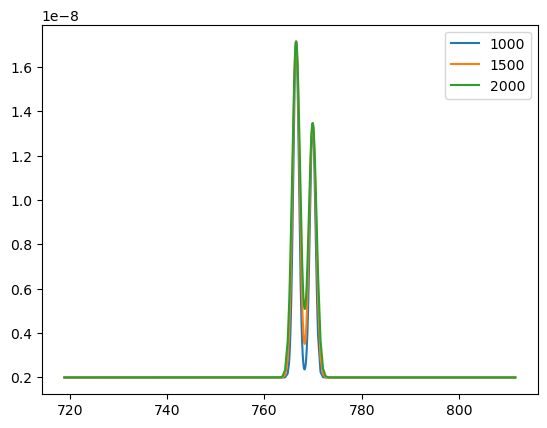

In [22]:
for T in [1000,1500,2000]:
    wave_nm = source_wavelength.wavelength.data
    Q = Q_absorption(T, wave_nm)
    plt.plot(wave_nm, Q, label=T)
plt.legend()

In [23]:
#from lmfit.lineshapes import gaussian, voigt

In [24]:
# voigt(x, amplitude=1.0, center=0.0, sigma=1.0, gamma=None)
# kappa = p1_prefactor*voigt(x, 1, p1_center, p1_delta_wl_D, p1_delta_wl_C) + p2_prefactor*voigt(x, 1, p2_center, p2_delta_wl_D, p2_delta_wl_C)